### Thiết lập môi trường
Chặn TensorFlow/Flax để tránh xung đột thư viện

In [2]:
import os

# Chặn Transformers tự động import TensorFlow/Flax (tránh lỗi protobuf / MessageFactory)
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TOKENIZERS_PARALLELISM"] = "false"


print("[OK] Environment flags set (no TF / no Flax).")

[OK] Environment flags set (no TF / no Flax).


### Kiểm tra GPU và dependencies
Hiển thị thông tin Python, PyTorch, CUDA và các thư viện

In [3]:
import sys, torch
import numpy as np

import transformers, datasets, accelerate

print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("Accelerate:", accelerate.__version__)

Python: 3.12.12
Torch: 2.8.0+cu126
CUDA: True
GPU: Tesla T4
Transformers: 4.57.1
Datasets: 4.4.1
Accelerate: 1.11.0


### Cài đặt packages bổ sung
- `sacrebleu`: Tính BLEU
- `hf_transfer`: Tăng tốc HF Hub

In [4]:
import importlib.util, subprocess

def pip_install(pkg: str):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# sacrebleu: bắt buộc
if importlib.util.find_spec("sacrebleu") is None:
    print("[INFO] Installing sacrebleu ...")
    pip_install("sacrebleu")
else:
    print("[OK] sacrebleu already installed")

# hf_transfer: optional tăng tốc push/pull
if importlib.util.find_spec("hf_transfer") is None:
    print("[INFO] Installing hf_transfer (optional) ...")
    pip_install("hf_transfer")
else:
    print("[OK] hf_transfer already installed")

[INFO] Installing sacrebleu ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.0 MB/s eta 0:00:00
[OK] hf_transfer already installed


### Import thư viện chính
Dataset, Tokenizer, Model, Trainer, sacrebleu

In [6]:
import re, math, random, hashlib
from pathlib import Path
from typing import List, Dict, Any

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    set_seed,
)
import sacrebleu

print("[OK] Imports done.")

[OK] Imports done.


### Tự động tìm dataset
Tìm thư mục chứa train.en/vi.txt và public_test

In [7]:
from pathlib import Path

def find_dataset_dir() -> Path:
    base = Path("/kaggle/input")
    for d in base.glob("*"):
        if d.is_dir() and (d / "train.en.txt").exists() and (d / "train.vi.txt").exists():
            return d
    for d in base.glob("*/*"):
        if d.is_dir() and (d / "train.en.txt").exists() and (d / "train.vi.txt").exists():
            return d
    raise FileNotFoundError("Could not find dataset folder containing train.en.txt/train.vi.txt")

DATA_DIR = find_dataset_dir()
print("[OK] Found dataset dir:", DATA_DIR)

TRAIN_EN = DATA_DIR / "train.en.txt"
TRAIN_VI = DATA_DIR / "train.vi.txt"
TEST_EN  = DATA_DIR / "public_test.en.txt"
TEST_VI  = DATA_DIR / "public_test.vi.txt"

for p in [TRAIN_EN, TRAIN_VI, TEST_EN, TEST_VI]:
    print("[CHECK]", p.name, "->", "OK" if p.exists() else "NOT FOUND")

[OK] Found dataset dir: /kaggle/input/databaitoanphu
[CHECK] train.en.txt -> OK
[CHECK] train.vi.txt -> OK
[CHECK] public_test.en.txt -> OK
[CHECK] public_test.vi.txt -> OK


### Load dữ liệu song song
Đọc 500k train pairs và 3k test pairs

In [8]:
SRC_LANG = "vi_VN"
TGT_LANG = "en_XX"
def read_lines(path: Path, encoding="utf-8"):
    with open(path, "r", encoding=encoding, errors="replace") as f:
        return [line.rstrip("\n") for line in f]

def load_parallel(en_path: Path, vi_path: Path, name="data"):
    en_lines = read_lines(en_path)
    vi_lines = read_lines(vi_path)
    n = min(len(en_lines), len(vi_lines))
    if len(en_lines) != len(vi_lines):
        print(f"[WARN] {name} mismatch -> EN={len(en_lines):,}, VI={len(vi_lines):,}. Using first {n:,} pairs.")
    else:
        print(f"[INFO] {name} lines -> {n:,} pairs.")
    return list(zip(vi_lines[:n], en_lines[:n]))

train_pairs_raw = load_parallel(TRAIN_EN, TRAIN_VI, "train_raw")
test_pairs_raw  = load_parallel(TEST_EN,  TEST_VI,  "test_raw")

print("[SAMPLE train_raw]", train_pairs_raw[0])
print("[SAMPLE test_raw ]", test_pairs_raw[0])

[INFO] train_raw lines -> 500,000 pairs.
[INFO] test_raw lines -> 3,000 pairs.
[SAMPLE train_raw] ('Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên', 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital')
[SAMPLE test_raw ] ('Thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh Viêng Chăn, CHDCND Lào, năm 2017', 'Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao')


### Làm sạch và lọc dữ liệu
Clean → Filter → Dedup: 500k → 340k pairs

In [9]:
import re, hashlib

def basic_clean(s: str) -> str:
    s = "" if s is None else s
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

MIN_CHARS = 2
MAX_CHARS = 400

def is_good_pair(src: str, tgt: str) -> bool:
    if not src or not tgt:
        return False
    if len(src) < MIN_CHARS or len(tgt) < MIN_CHARS:
        return False
    if len(src) > MAX_CHARS or len(tgt) > MAX_CHARS:
        return False
    return True

def clean_filter_dedup(pairs, name="data"):
    # clean + filter
    cleaned = []
    for src, tgt in pairs:
        src = basic_clean(src)
        tgt = basic_clean(tgt)
        if is_good_pair(src, tgt):
            cleaned.append((src, tgt))
    print(f"[INFO] {name}: after clean+filter -> {len(cleaned):,} pairs")

    # dedup
    seen = set()
    dedup = []
    for src, tgt in cleaned:
        h = hashlib.md5((src + "\t" + tgt).encode("utf-8")).hexdigest()
        if h not in seen:
            seen.add(h)
            dedup.append((src, tgt))
    print(f"[INFO] {name}: after dedup       -> {len(dedup):,} pairs")
    return dedup

train_pairs = clean_filter_dedup(train_pairs_raw, "train")
test_pairs  = clean_filter_dedup(test_pairs_raw,  "test")

print("[SAMPLE clean train]", train_pairs[0])
print("[SAMPLE clean test ]", test_pairs[0])

[INFO] train: after clean+filter -> 489,008 pairs
[INFO] train: after dedup       -> 340,522 pairs
[INFO] test: after clean+filter -> 2,946 pairs
[INFO] test: after dedup       -> 2,943 pairs
[SAMPLE clean train] ('Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên', 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital')
[SAMPLE clean test ] ('Thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh Viêng Chăn, CHDCND Lào, năm 2017', 'Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao')


### Chia train/val/test
30k pairs: Train (29,250) | Val (750) | Test (2,943)

In [10]:
import random
from datasets import Dataset, DatasetDict

SEED = 42
N_TOTAL = 30000

TRAIN_RATIO = 0.975  # 90/10

# 1) shuffle train_pairs
rng = random.Random(SEED)
rng.shuffle(train_pairs)

# 2) lấy 5000 (nếu không đủ thì lấy hết)
n_take = min(N_TOTAL, len(train_pairs))
subset = train_pairs[:n_take]
print(f"[INFO] Train pairs available: {len(train_pairs):,}")
print(f"[INFO] Taking from train     : {n_take:,} pairs")

# 3) split 90/10
n_train = int(n_take * TRAIN_RATIO)
n_val = n_take - n_train

train_subset = subset[:n_train]
val_subset   = subset[n_train:]

print(f"[INFO] Split -> train={len(train_subset):,} | val={len(val_subset):,}")

# 4) build datasets
train_ds = Dataset.from_dict({
    "src_text": [s for s, _ in train_subset],
    "tgt_text": [t for _, t in train_subset],
})
val_ds = Dataset.from_dict({
    "src_text": [s for s, _ in val_subset],
    "tgt_text": [t for _, t in val_subset],
})

# test giữ nguyên từ public_test
test_ds = Dataset.from_dict({
    "src_text": [s for s, _ in test_pairs],
    "tgt_text": [t for _, t in test_pairs],
})

ds = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})
print(ds)

print("[SAMPLE TRAIN]", ds["train"][0])
print("[SAMPLE VAL  ]", ds["validation"][0])
print("[SAMPLE TEST ]", ds["test"][0])

[INFO] Train pairs available: 340,522
[INFO] Taking from train     : 30,000 pairs
[INFO] Split -> train=29,250 | val=750
DatasetDict({
    train: Dataset({
        features: ['src_text', 'tgt_text'],
        num_rows: 29250
    })
    validation: Dataset({
        features: ['src_text', 'tgt_text'],
        num_rows: 750
    })
    test: Dataset({
        features: ['src_text', 'tgt_text'],
        num_rows: 2943
    })
})
[SAMPLE TRAIN] {'src_text': 'Theo dõi và kiểm soát ICP bằng cách sử dụng thuốc an thần, đặt nội khí quản, tăng thông khí, hydrat hoá, thuốc lợi tiểu, các biện pháp để kiểm soát huyết áp, và đôi khi là corticosteroid.', 'tgt_text': 'Monitor and control ICP using sedatives, endotracheal intubation, hyperventilation, hydration, diuretics, measures to control blood pressure, and sometimes corticosteroids.'}
[SAMPLE VAL  ] {'src_text': 'Do đó chúng tôi khảo sát sự biều hiện của gene hGRα ở các bệnh nhân VMXM có polyp mũi.', 'tgt_text': 'Therefore, we do a study about the 

### Load mBART-50 base
Model: facebook/mbart-large-50 (vi_VN → en_XX)

In [16]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

MODEL_ID = "facebook/mbart-large-50-many-to-many-mmt"
SRC_LANG = "vi_VN"
TGT_LANG = "en_XX"

tokenizer1 = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=False)
model1 = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID)

# set src/tgt language (QUAN TRỌNG)
tokenizer1.src_lang = SRC_LANG
tokenizer1.tgt_lang = TGT_LANG   # <-- FIX KeyError: None

forced_bos_token_id = tokenizer1.lang_code_to_id[TGT_LANG]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

print("[OK] tokenizer/model loaded")
print("[INFO] tokenizer.src_lang:", tokenizer1.src_lang)
print("[INFO] tokenizer.tgt_lang:", tokenizer1.tgt_lang)
print("[INFO] forced_bos_token_id:", forced_bos_token_id)


[OK] tokenizer/model loaded
[INFO] tokenizer.src_lang: vi_VN
[INFO] tokenizer.tgt_lang: en_XX
[INFO] forced_bos_token_id: 250004


### Tokenize dataset
Chuyển text → token IDs (max_length=256)

In [17]:
# đảm bảo ds đã có ở cell split 5000 (train/validation/test)
assert "ds" in globals(), "You must run the data-loading/splitting cell to create `ds` first!"
assert "tokenizer" in globals(), "You must run the tokenizer/model loading cell first!"

MAX_SRC_LEN = 256
MAX_TGT_LEN = 256

def preprocess_batch(batch):
    tokenizer.src_lang = SRC_LANG

    model_inputs = tokenizer(
        batch["src_text"],
        max_length=MAX_SRC_LEN,
        truncation=True,
        padding=False,
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["tgt_text"],
            max_length=MAX_TGT_LEN,
            truncation=True,
            padding=False,
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_tok = ds["train"].map(preprocess_batch, batched=True, remove_columns=ds["train"].column_names)
val_tok   = ds["validation"].map(preprocess_batch, batched=True, remove_columns=ds["validation"].column_names)
test_tok  = ds["test"].map(preprocess_batch, batched=True, remove_columns=ds["test"].column_names)

print("[OK] Tokenized sizes:",
      "train", len(train_tok),
      "| val", len(val_tok),
      "| test", len(test_tok))

Map:   0%|          | 0/29250 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Map:   0%|          | 0/2943 [00:00<?, ? examples/s]

[OK] Tokenized sizes: train 29250 | val 750 | test 2943


### Hàm translate
`translate_vi2en()` với beam search (num_beams=5)

In [18]:
import torch
from typing import List

MAX_SRC_LEN = 256

@torch.inference_mode()
def translate_vi2en(
    texts: List[str],
    num_beams: int = 5,
    length_penalty: float = 1.0,
    no_repeat_ngram_size: int = 3,
    max_new_tokens: int = 128,
):
    model.eval()
    tokenizer.src_lang = SRC_LANG
    tokenizer.tgt_lang = TGT_LANG

    enc = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_SRC_LEN
    ).to(model.device)

    generated = model.generate(
        **enc,
        forced_bos_token_id=tokenizer.lang_code_to_id[TGT_LANG],
        num_beams=num_beams,
        length_penalty=length_penalty,
        no_repeat_ngram_size=no_repeat_ngram_size,
        max_new_tokens=max_new_tokens,
        early_stopping=True,
    )

    return tokenizer.batch_decode(generated, skip_special_tokens=True)


### Baseline BLEU
Đánh giá model chưa fine-tune → BLEU = 17.77

In [19]:
#Bleu trước khi train
def bleu_on_test(max_samples=None):
    srcs = ds["test"]["src_text"]
    refs = ds["test"]["tgt_text"]

    if max_samples is not None:
        srcs = srcs[:max_samples]
        refs = refs[:max_samples]

    hyps = []
    bs = 16 if torch.cuda.is_available() else 4
    for i in range(0, len(srcs), bs):
        hyps.extend(translate_vi2en(srcs[i:i+bs]))

    bleu = sacrebleu.corpus_bleu(hyps, [refs]).score
    print(f"[TEST] sacreBLEU ({len(srcs)} samples): {bleu:.2f}")
    return bleu
_ = bleu_on_test(max_samples=200) 

[TEST] sacreBLEU (200 samples): 17.77


### Login Hugging Face
Xác thực HF_TOKEN từ Kaggle Secrets

In [10]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

user_secrets = UserSecretsClient()

# tên secret của anh là HF_TOKEN (đúng như panel)
hf_token = user_secrets.get_secret("HF_TOKEN")

login(token=hf_token)
print("[OK] Logged in to Hugging Face.")

[OK] Logged in to Hugging Face.


### Load checkpoint đã train
Load model ngothuyet/mbart50-vien để train tiếp

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

HF_REPO = "ngothuyet/mbart50-vien"

tokenizer = AutoTokenizer.from_pretrained(HF_REPO, use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained(HF_REPO)

tokenizer.src_lang = "vi_VN"
tokenizer.tgt_lang = "en_XX"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("[OK] Loaded model from HF:", HF_REPO)

tokenizer_config.json:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

[OK] Loaded model from HF: ngothuyet/mbart50-vien


### Tokenize lại dataset
Tokenize với tokenizer mới

In [12]:


MAX_SRC_LEN = 256
MAX_TGT_LEN = 256

def preprocess_batch(batch):
    tokenizer.src_lang = SRC_LANG

    model_inputs = tokenizer(
        batch["src_text"],
        max_length=MAX_SRC_LEN,
        truncation=True,
        padding=False,
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["tgt_text"],
            max_length=MAX_TGT_LEN,
            truncation=True,
            padding=False,
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_tok = ds["train"].map(preprocess_batch, batched=True, remove_columns=ds["train"].column_names)
val_tok   = ds["validation"].map(preprocess_batch, batched=True, remove_columns=ds["validation"].column_names)
test_tok  = ds["test"].map(preprocess_batch, batched=True, remove_columns=ds["test"].column_names)

print("[OK] Tokenized sizes:",
      "train", len(train_tok),
      "| val", len(val_tok),
      "| test", len(test_tok))

Map:   0%|          | 0/29250 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Map:   0%|          | 0/2943 [00:00<?, ? examples/s]

[OK] Tokenized sizes: train 29250 | val 750 | test 2943


### Fine-tuning
Train 3 epochs, LR=1e-5, Early stopping

In [12]:
import os, inspect
import torch
import pandas as pd
from transformers import (
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback,
)


tokenizer.src_lang = SRC_LANG
tokenizer.tgt_lang = TGT_LANG

OUTPUT_DIR  = "mbart50_vien"
NUM_EPOCHS  = 3

TRAIN_BS = 2
EVAL_BS  = 2
GRAD_ACC = 4
LR       = 1e-5

HF_REPO_ID = "ngothuyet/mbart50-vien"
HF_PRIVATE = True

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

ta_kwargs = dict(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,

    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=EVAL_BS,
    gradient_accumulation_steps=GRAD_ACC,
    learning_rate=LR,
    warmup_ratio=0.03,
    weight_decay=0.01,

    predict_with_generate=False,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    report_to="none",
    
    # ✅ SAVE BEST theo VAL LOSS (eval_loss)
    save_strategy="epoch",        # cần save để chọn best
    save_only_model=True,         # tránh lỗi optimizer.pt
    save_total_limit=1,           # chỉ giữ 1 cái tốt nhất

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

sig = inspect.signature(Seq2SeqTrainingArguments.__init__).parameters

if "logging_strategy" in sig:
    ta_kwargs["logging_strategy"] = "epoch"

if "evaluation_strategy" in sig:
    ta_kwargs["evaluation_strategy"] = "epoch"
elif "eval_strategy" in sig:
    ta_kwargs["eval_strategy"] = "epoch"
else:
    raise ValueError("Transformers version: missing evaluation_strategy/eval_strategy")

ta_kwargs.update(dict(
    push_to_hub=True,
    hub_model_id=HF_REPO_ID,
    hub_private_repo=HF_PRIVATE,
    hub_strategy="end",           # chỉ push cuối
))

training_args = Seq2SeqTrainingArguments(**ta_kwargs)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)], 
)

print("[INFO] Start training...")
train_result = trainer.train()
print("\n===== TRAIN DONE =====")
print(train_result)

print("\n===== BEST (by eval_loss) =====")
print("best_model_checkpoint:", trainer.state.best_model_checkpoint)
print("best_metric(eval_loss):", trainer.state.best_metric)

print("\n===== FINAL EVAL (VAL) on BEST =====")
final_metrics = trainer.evaluate()
for k, v in final_metrics.items():
    print(f"{k}: {v}")

# Lưu BEST local (trainer.model đã là best vì load_best_model_at_end=True)
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print("[OK] Saved BEST model/tokenizer to:", OUTPUT_DIR)

# TSV train/val loss như cũ
logs = trainer.state.log_history
train_loss_by_epoch = {}
val_loss_by_epoch = {}

for row in logs:
    if "epoch" in row and "loss" in row and "eval_loss" not in row:
        train_loss_by_epoch[row["epoch"]] = row["loss"]
    if "epoch" in row and "eval_loss" in row:
        val_loss_by_epoch[row["epoch"]] = row["eval_loss"]

epochs = sorted(set(list(train_loss_by_epoch.keys()) + list(val_loss_by_epoch.keys())))
df = pd.DataFrame({
    "epoch": epochs,
    "train_loss": [train_loss_by_epoch.get(e, None) for e in epochs],
    "val_loss": [val_loss_by_epoch.get(e, None) for e in epochs],
})

tsv_path = os.path.join(OUTPUT_DIR, "train_val_loss.tsv")
df.to_csv(tsv_path, sep="\t", index=False)
print("[OK] Saved TSV:", tsv_path)
display(df)

# ✅ Push BEST + TSV (không còn push “bản cuối” theo nghĩa last-epoch)
trainer.push_to_hub(commit_message=f"Push BEST by eval_loss={trainer.state.best_metric} + train_val_loss.tsv")
print("[OK] Pushed BEST model + TSV to Hugging Face.")


### Hàm inference
`translate_vi2en()` với memory cleanup

In [13]:
# @torch.inference_mode()
# def translate_en2vi(texts, num_beams=5, length_penalty=1.0, no_repeat_ngram_size=3, max_new_tokens=128):
#     model.eval()
#     tokenizer.src_lang = SRC_LANG
#     enc = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_SRC_LEN).to(model.device)
#     out = model.generate(
#         **enc,
#         forced_bos_token_id=tokenizer.lang_code_to_id[TGT_LANG],
#         num_beams=num_beams,
#         length_penalty=length_penalty,
#         no_repeat_ngram_size=no_repeat_ngram_size,
#         max_new_tokens=max_new_tokens,
#         early_stopping=True
#     )
#     return tokenizer.batch_decode(out, skip_special_tokens=True)

import torch
from typing import List

MAX_SRC_LEN = 256

@torch.inference_mode()
def translate_vi2en(
    texts,
    model_,
    tokenizer_,
    num_beams=1,              # ✅ quan trọng nhất
    max_new_tokens=80,
):
    model_.eval()
    tokenizer_.src_lang = SRC_LANG
    tokenizer_.tgt_lang = TGT_LANG

    with torch.no_grad():      # ✅ BẮT BUỘC
        enc = tokenizer_(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_SRC_LEN
        ).to(model_.device)

        generated = model_.generate(
            **enc,
            forced_bos_token_id=tokenizer_.lang_code_to_id[TGT_LANG],
            num_beams=num_beams,
            max_new_tokens=max_new_tokens,
            early_stopping=True,
        )

    out = tokenizer_.batch_decode(generated, skip_special_tokens=True)

    # ✅ dọn VRAM
    del enc, generated
    torch.cuda.empty_cache()

    return out

# Demo nhanh
demo = [
    "Tôi muốn đi ngủ vì tôi bị đau mắt"
]
print("[INPUT ]", demo)
print("[OUTPUT]", translate_vi2en(demo, model, tokenizer, num_beams=5))





[INPUT ] ['Tôi muốn đi ngủ vì tôi bị đau mắt']
[OUTPUT] ['I want to go to bed because I have eye pain.']


### Visualize loss
Download và vẽ train_loss vs val_loss

train_val_loss.tsv:   0%|          | 0.00/115 [00:00<?, ?B/s]

[OK] Downloaded: /root/.cache/huggingface/hub/models--ngothuyet--mbart50-vien/snapshots/3e9be8a49b4247d5a6e0c9c411c4b88423995497/train_val_loss.tsv


,epoch,train_loss,val_loss
0,1.0,1.2808,1.454767
1,2.0,1.1283,1.443353
2,3.0,1.0355,1.443353


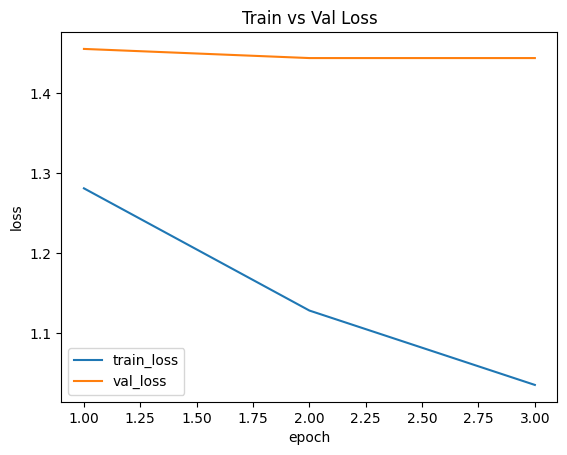

In [14]:
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt

REPO_ID  = "ngothuyet/mbart50-vien"
FILENAME = "train_val_loss.tsv"

# tải file về kaggle
local_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
print("[OK] Downloaded:", local_path)

# đọc TSV
df = pd.read_csv(local_path, sep="\t")
display(df.head(10))

# # lấy điểm gãy epoch 4
# knee_epoch = 4
# row = df.loc[df["epoch"] == knee_epoch].iloc[0]
# xk, yk = float(row["epoch"]), float(row["val_loss"])

# ===== VẼ BIỂU ĐỒ =====
plt.figure()
plt.plot(df["epoch"], df["train_loss"], label="train_loss")
plt.plot(df["epoch"], df["val_loss"], label="val_loss")

# # đánh dấu điểm gãy
# plt.scatter([xk], [yk], color="red", zorder=5)
# plt.annotate(
#     "Điểm gãy (epoch 4)",
#     xy=(xk, yk),
#     xytext=(xk + 0.8, yk + 0.08),
#     arrowprops=dict(arrowstyle="->", color="red", lw=2),
#     color="red"
# )

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.show()


### Load test data
Đọc lại public_test để tính BLEU full

In [14]:
from datasets import Dataset

# đọc song song public_test.en/vi -> list[(en, vi)]
test_pairs_raw = load_parallel(TEST_EN, TEST_VI, "test_raw")

# clean/filter/dedup giống pipeline train
test_pairs = clean_filter_dedup(test_pairs_raw, "test")

print(f"[INFO] public_test after clean: {len(test_pairs):,} pairs")
print("[SAMPLE TEST]", test_pairs[0])

# tạo ds_test (giữ nguyên ds train/val của anh nếu đã có)
test_ds = Dataset.from_dict({
    "src_text": [s for s, _ in test_pairs],
    "tgt_text": [t for _, t in test_pairs],
})

# gắn vào DatasetDict nếu đã có ds, còn không thì tạo ds mới
if "ds" in globals():
    ds["test"] = test_ds
else:
    from datasets import DatasetDict
    ds = DatasetDict({"test": test_ds})

print("[OK] ds['test'] size:", len(ds["test"]))

[INFO] test_raw lines -> 3,000 pairs.
[INFO] test: after clean+filter -> 2,946 pairs
[INFO] test: after dedup       -> 2,943 pairs
[INFO] public_test after clean: 2,943 pairs
[SAMPLE TEST] ('Thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh Viêng Chăn, CHDCND Lào, năm 2017', 'Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao')
[OK] ds['test'] size: 2943


### BLEU trên test set
Dịch 2,943 câu → **BLEU = 31.75**

In [22]:
import os, json, time
import torch
import sacrebleu
from tqdm.auto import tqdm


OUTPUT_DIR  = "mbart50_vien"
def bleu_on_public_test_and_push(batch_size=16):
    srcs = ds["test"]["src_text"]
    refs = ds["test"]["tgt_text"]

    bs = batch_size if torch.cuda.is_available() else max(2, batch_size // 4)

    hyps = []
    t0 = time.time()

    for i in tqdm(range(0, len(srcs), bs), desc="BLEU on public_test", total=(len(srcs) + bs - 1)//bs):
        batch = srcs[i:i+bs]
        hyps.extend(
            translate_vi2en(
                batch,
                num_beams=3,
                max_new_tokens=80
            )
        )

    bleu = sacrebleu.corpus_bleu(hyps, [refs]).score
    elapsed = time.time() - t0

    metrics = {
        "public_test_sacrebleu": float(bleu),
        "public_test_size": int(len(srcs)),
        "batch_size": int(bs),
        "elapsed_sec": float(elapsed),
    }

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    json_path = os.path.join(OUTPUT_DIR, "public_test_metrics.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)

    txt_path = os.path.join(OUTPUT_DIR, "public_test_bleu.txt")
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(f"public_test_sacrebleu\t{bleu:.4f}\n")

    print(f"\n[PUBLIC_TEST] sacreBLEU ({len(srcs)} samples): {bleu:.2f}")
    print("[OK] Saved:", json_path)
    print("[OK] Saved:", txt_path)

    # push lên repo model
    trainer.push_to_hub(commit_message=f"Add public_test sacreBLEU={bleu:.2f}")
    print("[OK] Pushed public_test BLEU files to Hugging Face.")

    return bleu, metrics

_ = bleu_on_public_test_and_push(batch_size=16)

BLEU on public_test:   0%|          | 0/184 [00:00<?, ?it/s]


[PUBLIC_TEST] sacreBLEU (2943 samples): 31.75
[OK] Saved: mbart50_vien/public_test_metrics.json
[OK] Saved: mbart50_vien/public_test_bleu.txt


NameError: name 'trainer' is not defined

### Hiển thị 5 mẫu dịch
Kiểm tra chất lượng dịch

In [15]:


N_SHOW = 5  # số dòng muốn in

srcs = ds["test"]["src_text"][:N_SHOW]
tgts = ds["test"]["tgt_text"][:N_SHOW]

# dịch
preds = translate_vi2en(
    srcs,
    model,
    tokenizer,
    num_beams=3,
    length_penalty=1.0,
    no_repeat_ngram_size=3,
    max_new_tokens=80,
)

print("=" * 100)
for i, (src, tgt, pred) in enumerate(zip(srcs, tgts, preds), start=1):
    print(f"[{i}] SRC (VI): {src}")
    print(f"    TGT (EN): {tgt}")
    print(f"    PRED(EN): {pred}")
    print("-" * 100)
print("=" * 100)

[1] SRC (VI): Thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh Viêng Chăn, CHDCND Lào, năm 2017
    TGT (EN): Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao
    PRED(EN): Current knowledge and practice of health insurance card holders in using medical examination services in public health facilities and some influencing factors in Janch Chan province, Lao People's Democratic Congress, 2017
----------------------------------------------------------------------------------------------------
[2] SRC (VI): Mô tả thực trạng kiến thức, thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố liên quan tại tỉnh Viêng Chăn, Cộng hoà Dân chủ Nhân dân Lào năm 2017.
    TGT (EN): Describe knowledge, practices in public health service utili

### Error Analysis helpers
Hàm trích xuất số, NE, phát hiện repetition

In [22]:
import re
from collections import Counter
import pandas as pd

# =========================
# Helpers
# =========================
_num_pat = re.compile(r"\d+(?:[.,:/-]\d+)*")
_word_pat = re.compile(r"[A-Za-zÀ-ỹ]+(?:'[A-Za-zÀ-ỹ]+)?|\d+(?:[.,:/-]\d+)*", re.UNICODE)

def _tokenize(s: str):
    return _word_pat.findall((s or "").strip())

def _extract_numbers(s: str):
    return set(_num_pat.findall((s or "")))

def _extract_capitalized_words(s: str):
    # tên riêng đơn giản: token bắt đầu bằng chữ hoa
    toks = _tokenize(s)
    out = set()
    for t in toks:
        if len(t) >= 2 and t[0].isupper() and any(c.isalpha() for c in t):
            out.add(t)
    return out

def _ngram_counts(tokens, n=3):
    if len(tokens) < n:
        return Counter()
    return Counter(tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1))

def _has_repetition(tokens):
    # lặp n-gram: bigram lặp >=3 hoặc trigram lặp >=2
    c2 = _ngram_counts(tokens, n=2)
    c3 = _ngram_counts(tokens, n=3)
    rep2 = (len(c2) > 0) and (max(c2.values()) >= 3)
    rep3 = (len(c3) > 0) and (max(c3.values()) >= 2)
    return rep2 or rep3

def _untranslated_vi_chars(text: str):
    # nếu output EN mà vẫn có nhiều ký tự tiếng Việt
    vi_chars = set("ăâđêôơưáàảãạắằẳẵặấầẩẫậéèẻẽẹếềểễệ"
                   "íìỉĩịóòỏõọốồổỗộớờởỡợúùủũụứừửữựýỳỷỹỵ")
    t = (text or "").lower()
    return sum(1 for ch in t if ch in vi_chars)

def _jaccard(a, b):
    a, b = set(a), set(b)
    if not a and not b:
        return 1.0
    if not a or not b:
        return 0.0
    return len(a & b) / len(a | b)

# =========================
# Core tagger (rule-based)
# =========================
def tag_mt_errors(
    src: str, ref: str, hyp: str,
    direction="vi-en",
    omission_ratio=0.75,
    addition_ratio=1.35,
    overlap_literal_thr=0.55,
):
    src = src or ""
    ref = ref or ""
    hyp = hyp or ""

    src_toks = _tokenize(src.lower())
    ref_toks = _tokenize(ref.lower())
    hyp_toks = _tokenize(hyp.lower())

    len_ref = max(1, len(ref_toks))
    len_hyp = len(hyp_toks)
    len_ratio = len_hyp / len_ref

    nums_ref = _extract_numbers(ref)
    nums_hyp = _extract_numbers(hyp)

    caps_ref = _extract_capitalized_words(ref)
    caps_hyp = _extract_capitalized_words(hyp)

    overlap_ref_hyp = _jaccard(ref_toks, hyp_toks)
    overlap_src_hyp = _jaccard(src_toks, hyp_toks)

    tags = []

    # Omission / Addition (length)
    if len_ratio < omission_ratio:
        tags.append("Omission_length")
    if len_ratio > addition_ratio:
        tags.append("Addition_length")

    # Numbers / Named Entities mismatch
    if (nums_ref - nums_hyp):
        tags.append("Number_mismatch_omit")
    if (nums_hyp - nums_ref):
        tags.append("Number_mismatch_add")

    if (caps_ref - caps_hyp):
        tags.append("NE_mismatch_omit")
    if (caps_hyp - caps_ref):
        tags.append("NE_mismatch_add")

    # Repetition
    if _has_repetition(hyp_toks):
        tags.append("Repetition")

    # Untranslated / Literal suspects
    if direction == "vi-en":
        if _untranslated_vi_chars(hyp) >= 3:
            tags.append("Untranslated")
        if overlap_src_hyp >= overlap_literal_thr:
            tags.append("Literal_translation_suspect")
    else:  # en-vi
        en_like = sum(1 for ch in hyp if ('A' <= ch <= 'Z') or ('a' <= ch <= 'z'))
        if en_like >= 12 and len(hyp) >= 25:
            tags.append("Untranslated")
        if overlap_src_hyp >= overlap_literal_thr:
            tags.append("Literal_translation_suspect")

    # Punctuation/style (tham chiếu có .?! nhưng hyp không có)
    if ref.strip() and hyp.strip():
        if (ref.strip()[-1] in ".?!") and (hyp.strip()[-1] not in ".?!"):
            tags.append("Punctuation_style")

    # Terminology miss (heuristic): token dài (>=12) có trong ref nhưng mất trong hyp
    long_ref = {t for t in ref_toks if len(t) >= 12}
    if (long_ref - set(hyp_toks)):
        tags.append("Terminology_miss_suspect")

    # Semantic suspect (proxy): không rõ omission/addition nhưng overlap ref-hyp rất thấp
    if ("Omission_length" not in tags) and ("Addition_length" not in tags):
        if (overlap_ref_hyp < 0.25) and (len_ref >= 6):
            tags.append("Semantic_mismatch_suspect")

    info = {
        "len_ratio(hyp/ref)": round(len_ratio, 3),
        "overlap_ref_hyp": round(overlap_ref_hyp, 3),
        "overlap_src_hyp": round(overlap_src_hyp, 3),
        "nums_ref_missing_in_hyp": sorted(nums_ref - nums_hyp),
        "nums_hyp_extra_vs_ref": sorted(nums_hyp - nums_ref),
        "NE_ref_missing_in_hyp": sorted(caps_ref - caps_hyp),
        "NE_hyp_extra_vs_ref": sorted(caps_hyp - caps_ref),
        "error_tags": ", ".join(tags),
    }
    return tags, info

# =========================
# End-to-end: run on your ds["test"]
# =========================
def run_error_analysis_on_ds(
    ds,
    split="test",
    translate_fn=translate_vi2en,         # ví dụ: translate_vi2en
    direction="vi-en",
    batch_size=16,
    max_samples=None,
):
    assert translate_fn is not None, "Anh truyền translate_fn vào (ví dụ translate_vi2en)."

    srcs = ds[split]["src_text"]
    refs = ds[split]["tgt_text"]

    if max_samples is not None:
        srcs = srcs[:max_samples]
        refs = refs[:max_samples]

    # 1) generate hyps theo batch (giống code BLEU của anh)
    hyps = []
    for i in range(0, len(srcs), batch_size):
        hyps.extend(translate_fn(srcs[i:i+batch_size], model, tokenizer))

    # 2) tag lỗi
    rows = []
    counts = Counter()

    for i, (src, ref, hyp) in enumerate(zip(srcs, refs, hyps)):
        tags, info = tag_mt_errors(src, ref, hyp, direction=direction)
        for t in tags:
            counts[t] += 1

        rows.append({
            "id": i,
            "src": src,
            "ref": ref,
            "hyp": hyp,
            **info
        })

    df_err = pd.DataFrame(rows)
    summary = pd.DataFrame(
        [{"error_type": k, "count": v, "rate": v/len(df_err)} for k, v in counts.most_common()]
    )

    return df_err, summary


### Chạy Error Analysis
Tag lỗi: NE_mismatch (61%), Terminology_miss (33%)

In [23]:
df_err, summary = run_error_analysis_on_ds(
    ds=ds,
    split="test",
    translate_fn=translate_vi2en,
    direction="vi-en",
    batch_size=16,
    max_samples=200  # bỏ dòng này nếu muốn chạy full
)

display(summary)
display(df_err[df_err["error_tags"] != ""].head(20))


,error_type,count,rate
0,NE_mismatch_omit,123,0.615
1,NE_mismatch_add,121,0.605
2,Terminology_miss_suspect,67,0.335
3,Number_mismatch_add,23,0.115
4,Number_mismatch_omit,23,0.115
5,Addition_length,18,0.090
6,Omission_length,11,0.055
7,Repetition,9,0.045
8,Semantic_mismatch_suspect,7,0.035
9,Punctuation_style,5,0.025


,id,src,ref,hyp,len_ratio(hyp/ref),overlap_ref_hyp,overlap_src_hyp,nums_ref_missing_in_hyp,nums_hyp_extra_vs_ref,NE_ref_missing_in_hyp,NE_hyp_extra_vs_ref,error_tags
0,0,Thực trạng kiến thức và thực hành của người có...,"Knowledge, practices in public health service ...",Current knowledge and practice of health insur...,1.632,0.333,0.015,[],[2017],"[Knowledge, Vientiane]","[Chan, Congress, Current, Democratic, Janch, P...","Addition_length, Number_mismatch_add, NE_misma..."
1,1,"Mô tả thực trạng kiến thức, thực hành của ngườ...","Describe knowledge, practices in public health...",To describe the current situation of knowledge...,1.714,0.275,0.013,[],[],"[Describe, PDR, Vientiane]","[Can, Democratic, Jan, People's, Republic, To]","Addition_length, NE_mismatch_omit, NE_mismatch..."
2,2,Phương pháp: Thiết kế nghiên mô tả cắt ngang đ...,Methodology: A cross sectional study was used ...,Methods: A cross-sectional descriptive study w...,1.174,0.471,0.109,[],[2],"[Methodology, Vientiane]","[Chan, Janch, Methods]","Number_mismatch_add, NE_mismatch_omit, NE_mism..."
3,3,Kết quả: Tỷ lệ người biết được khám chữa bệnh ...,Results: Percentage of card's holders who knew...,Results: The proportion of people who knew abo...,0.893,0.382,0.000,[],[],[Percentage],[The],"NE_mismatch_omit, NE_mismatch_add"
4,4,Tỷ lệ người có thẻ BHYT thực hành khám chữa bệ...,Percentage of card's holders who went to the f...,The proportion of people with health insurance...,1.600,0.167,0.000,[],[],[Percentage],[The],"Addition_length, NE_mismatch_omit, NE_mismatch..."
5,5,Tỷ lệ người có thẻ BHYT sử dụng thẻ để lấy thu...,Percentage of card's holders who went to publi...,The proportion of people with health insurance...,1.000,0.267,0.000,[],[],[Percentage],[The],"NE_mismatch_omit, NE_mismatch_add"
6,6,"Các yếu tố khoảng cách từ nhà đến cơ sở y tế, ...",The determinants of knowledge and practices in...,Factors such as distance from home to healthca...,1.121,0.250,0.000,[],[],[The],[Factors],"NE_mismatch_omit, NE_mismatch_add, Repetition,..."
7,7,Kết luận: Kiến thức và thực hành của người có ...,Conclusions: Knowledge and practices in public...,Conclusion: The knowledge and practice of peop...,1.412,0.267,0.000,[],[],"[Conclusions, Knowledge]","[Conclusion, Democratic, Lao, People's, Republ...","Addition_length, NE_mismatch_omit, NE_mismatch..."
8,8,Cần tập trung vào truyền thông cho những nhóm ...,It's necessary to provide health insurance com...,It is necessary to focus on communication for ...,1.048,0.258,0.000,[],[],[It's],[It],"NE_mismatch_omit, NE_mismatch_add"
9,9,Nghiên cứu xác định thuốc diclofenac natri lẫn...,Studying the method of quantification of diclo...,Study on determination of diclofenac sodium in...,1.000,0.517,0.018,[],[],[Studying],[Study],"NE_mismatch_omit, NE_mismatch_add, Terminology..."


### Vẽ biểu đồ lỗi
Bar chart phân bố các loại lỗi

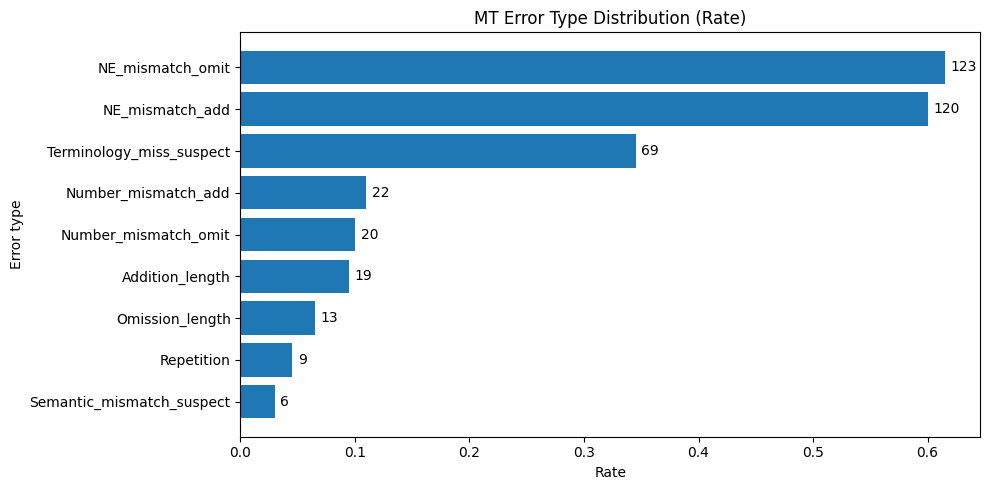

In [20]:
import matplotlib.pyplot as plt

# summary: DataFrame có các cột ["error_type","count","rate"]
# nếu summary của anh đang tên khác thì đổi lại biến

dfp = summary.sort_values("rate", ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(dfp["error_type"], dfp["rate"])
plt.xlabel("Rate")
plt.ylabel("Error type")
plt.title("MT Error Type Distribution (Rate)")

# ghi count lên mỗi cột
for i, (rate, cnt) in enumerate(zip(dfp["rate"], dfp["count"])):
    plt.text(rate + 0.005, i, f"{cnt}", va="center")  # +0.005 để chữ không đè lên cột

plt.tight_layout()
plt.show()


### Gemini Judge - Giới thiệu
Dùng Gemini API chấm điểm dịch (0-100)

In [24]:
# CELL 1: Init Gemini client (Kaggle)

from kaggle_secrets import UserSecretsClient
from google import genai
import os

# đọc secret
API_KEY = UserSecretsClient().get_secret("GeminiAPI")

# (tuỳ chọn) set env
os.environ["GeminiAPI"] = API_KEY

# init client
client = genai.Client(api_key=API_KEY)

print("✅ Gemini client initialized")


✅ Gemini client initialized


### Init Gemini client
Khởi tạo với GeminiAPI key

In [18]:
# CELL 2: Gemini judge functions

import json
import time
from typing import List, Tuple, Optional
from tqdm.auto import tqdm

JUDGE_SYSTEM = """You are a strict evaluator.
Score the candidate translation against the reference.
Return ONLY valid JSON:
{
  "score": integer from 0 to 100,
  "rationale": short Vietnamese explanation (1-2 sentences)
}
"""

def build_prompt(src_vi: str, ref_en: str, hyp_en: str) -> str:
    return f"""
SOURCE (VI):
{src_vi}

REFERENCE (EN):
{ref_en}

CANDIDATE (EN):
{hyp_en}
"""

def gemini_judge_one(
    src_vi: str,
    ref_en: str,
    hyp_en: str,
    model: str = "gemini-2.5-flash",
    max_retries: int = 8,
    base_sleep: float = 2.0,   # sleep nền
) -> Tuple[Optional[int], str]:
    prompt = build_prompt(src_vi, ref_en, hyp_en)
    last_err = ""

    for attempt in range(max_retries):
        try:
            resp = client.models.generate_content(
                model=model,
                contents=prompt,
                config={
                    "system_instruction": JUDGE_SYSTEM,
                    "temperature": 0.0,
                    "response_mime_type": "application/json",
                },
            )

            data = json.loads((resp.text or "").strip())
            score = int(data.get("score"))
            score = max(0, min(100, score))
            rationale = str(data.get("rationale", "")).strip()
            return score, rationale

        except Exception as e:
            last_err = str(e)

            # ✅ Nếu 429 RESOURCE_EXHAUSTED -> backoff mạnh dần
            if "429" in last_err or "RESOURCE_EXHAUSTED" in last_err:
                sleep = base_sleep * (2 ** attempt) + random.uniform(0, 1.0)
                print(f"[429] Rate limit/quota. Sleep {sleep:.1f}s (attempt {attempt+1}/{max_retries})")
                time.sleep(sleep)
                continue

            # lỗi khác: thử nhẹ 1 lần rồi trả
            time.sleep(1.0)

    return None, f"ERROR: {last_err}"

### Gemini judge function
`gemini_judge_one()` với retry logic

In [15]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

MODEL_ID = "facebook/mbart-large-50-many-to-many-mmt"
SRC_LANG = "vi_VN"
TGT_LANG = "en_XX"

tokenizer1 = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=False)
model1 = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID)

# set src/tgt language (QUAN TRỌNG)
tokenizer1.src_lang = SRC_LANG
tokenizer1.tgt_lang = TGT_LANG   # <-- FIX KeyError: None

forced_bos_token_id = tokenizer1.lang_code_to_id[TGT_LANG]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

print("[OK] tokenizer1/model loaded")
print("[INFO] tokenizer1.src_lang:", tokenizer1.src_lang)
print("[INFO] tokenizer1.tgt_lang:", tokenizer1.tgt_lang)
print("[INFO] forced_bos_token_id:", forced_bos_token_id)

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

[OK] tokenizer1/model loaded
[INFO] tokenizer1.src_lang: vi_VN
[INFO] tokenizer1.tgt_lang: en_XX
[INFO] forced_bos_token_id: 250004


### Load mBART-50 base
Model gốc để so sánh baseline

In [15]:
# Demo nhanh
demo = [
    "Tôi muốn đi ngủ vì tôi bị đau mắt"
]
print("[INPUT ]", demo)
print("[OUTPUT]", translate_vi2en(demo, model1, tokenizer1, num_beams=1))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[INPUT ] ['Tôi muốn đi ngủ vì tôi bị đau mắt']
[OUTPUT] ["I want to go to sleep because I'm having trouble seeing."]


### Test translate baseline
Demo dịch 1 câu

In [20]:
# CELL 3: Score first 200 public-test sentences

import pandas as pd
import matplotlib.pyplot as plt

# load test files (đã có trong notebook anh)
vi_src = read_lines(TEST_VI)
en_ref = read_lines(TEST_EN)

N = 30   # đổi 1 để test nhanh
vi_part = vi_src[:N]
ref_part = en_ref[:N]

# dịch (dùng hàm có sẵn của anh)
pred_part = translate_vi2en(vi_part, model1, tokenizer1)

rows = []
for i in tqdm(range(N), desc="Gemini scoring"):
    score, rationale = gemini_judge_one(
        src_vi=vi_part[i],
        ref_en=ref_part[i],
        hyp_en=pred_part[i],
    )
    rows.append({
        "idx": i,
        "vi_src": vi_part[i],
        "en_ref": ref_part[i],
        "en_pred": pred_part[i],
        "gemini_score": score,
        "rationale": rationale,
    })
    time.sleep(1)

df_gemini1 = pd.DataFrame(rows)






### Score bằng Gemini
Chấm 30 câu test

In [33]:
import pandas as pd



source_vi_list  = read_lines(TEST_EN)
ref_en_list        = read_lines(TEST_VI)

def ensure_idx(df):
    df = df.copy()
    if "idx" not in df.columns:
        df["idx"] = df.index
    return df

df1 = ensure_idx(df_gemini1)
df2 = ensure_idx(df_gemini2)

# ====== 3) Lấy hyp EN từ df (tự dò tên cột) hoặc từ biến list ======
def pick_col(df, names):
    for n in names:
        if n in df.columns:
            return n
    return None

hyp_col = pick_col(df2, ["hyp_en","en_hyp","en_pred","pred_en","vi2en","output_en","en_out"])
if hyp_col is None:
    hyp_col = pick_col(df1, ["hyp_en","en_hyp","en_pred","pred_en","vi2en","output_en","en_out"])

if hyp_col is not None:
    hyp_en_series = (df2[hyp_col] if hyp_col in df2.columns else df1[hyp_col])
else:
    # fallback: thử dùng biến prediction trong notebook (anh sửa đúng tên biến nếu có)
    if "pred_en" in globals():
        hyp_en_series = pd.Series(pred_en)
    elif "pred_part" in globals():
        hyp_en_series = pd.Series(pred_part)
    else:
        raise ValueError("Không tìm thấy hyp_en trong df_gemini1/df_gemini2 và cũng không có biến pred_en/pred_part.")

# ====== 4) Merge score/rationale ======
m = df1[["idx","gemini_score"]].rename(columns={"gemini_score":"score_df_gemini1"}) \
    .merge(
        df2[["idx","gemini_score","rationale"]].rename(columns={"gemini_score":"score_df_gemini2","rationale":"rationale_df_gemini2"}),
        on="idx",
        how="outer"
    ).sort_values("idx").reset_index(drop=True)

# ====== 5) Build output table ======
N = len(m)
out = pd.DataFrame({
    "STT": range(1, N+1),
    "source vi": source_vi_list[:N],
    "ref en": ref_en_list[:N],
    "hyp en": hyp_en_series.reset_index(drop=True)[:N],
    "score từ df_gemini1": m["score_df_gemini1"],
    "score từ df_gemini2": m["score_df_gemini2"],
    "rationale từ df_gemini2": m["rationale_df_gemini2"],
})

csv_name = "gemini_score_VI_EN.csv"   # ✅ đổi tên file theo VI->EN
out.to_csv(csv_name, index=False, encoding="utf-8")
print("✅ Saved:", csv_name)
out.head(5)

✅ Saved: gemini_score_VI_EN.csv


,STT,source vi,ref en,hyp en,score từ df_gemini1,score từ df_gemini2,rationale từ df_gemini2
0,1,"Knowledge, practices in public health service ...",Thực trạng kiến thức và thực hành của người có...,Current knowledge and practice of health insur...,50,50,Bản dịch ứng viên mắc lỗi nghiêm trọng khi dịc...
1,2,"Describe knowledge, practices in public health...","Mô tả thực trạng kiến thức, thực hành của ngườ...",To describe the current situation of knowledge...,40,65,Bản dịch ứng viên mắc lỗi nghiêm trọng khi dịc...


### Export CSV
Merge scores và lưu file

In [21]:
base_scores, ft_scores, reasons = [], [], []

for i in range(len(vi_part)):
    b_score, b_notes = score_one(base_hyp[i], en_ref[i])
    f_score, f_notes = score_one(ft_hyp[i], en_ref[i])

    base_scores.append(b_score)
    ft_scores.append(f_score)

    b_txt = "; ".join(b_notes) if b_notes else "đúng y khoa"
    f_txt = "; ".join(f_notes) if f_notes else "đúng y khoa"

    reasons.append(f"Base: {b_txt}. FT: {f_txt}.")

print("✅ Base mean:", sum(base_scores)/len(base_scores))
print("✅ FT mean:", sum(ft_scores)/len(ft_scores))


✅ Base mean: 54.81393797932644
✅ FT mean: 70.14271423807936


### Luật chấm Y Khoa
Tiêu đề markdown

In [22]:
import pandas as pd

# ✅ chọn câu dịch để lưu ở cột "câu đích được dịch"
# mặc định em lưu bản Fine-tuned (ft_hyp). Nếu muốn lưu Base thì đổi thành base_hyp
hyp_to_save = ft_hyp


df_out = pd.DataFrame({
    "stt": list(range(1, len(vi_part) + 1)),
    "câu nguồn": vi_part,
    "câu đích chuẩn từ tập test": en_ref,
    "câu đích được dịch": hyp_to_save,
    "base_score": base_scores,
    "ft_score": ft_scores,
    "reason": reasons,   # đã có "Base: ... FT: ..." và lỗi cụ thể
})

out_path = "gemini_score_EN_VI.csv"
df_out.to_csv(out_path, index=False, encoding="utf-8-sig")
print("✅ Saved:", out_path)

df_out.head(5)


✅ Saved: gemini_score_EN_VI.csv


,stt,câu nguồn,câu đích chuẩn từ tập test,câu đích được dịch,base_score,ft_score,reason
0,1,"Mô tả thực trạng kiến thức, thực hành của ngườ...","Describe knowledge, practices in public health...",To describe the knowledge and practice of heal...,5,80,Base: Cụm danh từ ghép y khoa mơ hồ (−20); Lỗi...
1,2,Phương pháp: Thiết kế nghiên mô tả cắt ngang đ...,Methodology: A cross sectional study was used ...,Methods: Cross-sectional study was conducted o...,80,80,Base: Cụm danh từ ghép y khoa mơ hồ (−20). FT:...
2,3,Kết quả: Tỷ lệ người biết được khám chữa bệnh ...,Results: Percentage of card's holders who knew...,Results: The proportion of people who knew abo...,80,80,Base: Cụm danh từ ghép y khoa mơ hồ (−20). FT:...
3,4,Tỷ lệ người có thẻ BHYT thực hành khám chữa bệ...,Percentage of card's holders who went to the f...,The proportion of people with health insurance...,80,80,Base: Cụm danh từ ghép y khoa mơ hồ (−20). FT:...
4,5,Tỷ lệ người có thẻ BHYT sử dụng thẻ để lấy thu...,Percentage of card's holders who went to publi...,The proportion of people with health insurance...,80,80,Base: Cụm danh từ ghép y khoa mơ hồ (−20). FT:...


### So sánh Base vs FT
Base: 54.8, FT: 70.1 (+15.3)